In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from mpl_toolkits.mplot3d import Axes3D
import pylab
import plotly.offline as py
import plotly.graph_objs as go
import colorsys
from sklearn.model_selection import train_test_split
%matplotlib inline

from utils import *

# Loading SAR data

In [2]:
train = pd.read_json('input/train.json', orient='records')
train.inc_angle = train.inc_angle.replace('na',0)
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


# Data Visualization & EDA

In [3]:
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [4]:
rgb_train, hsv_train = RGB_HSV_composite(train)

Looking at random ships


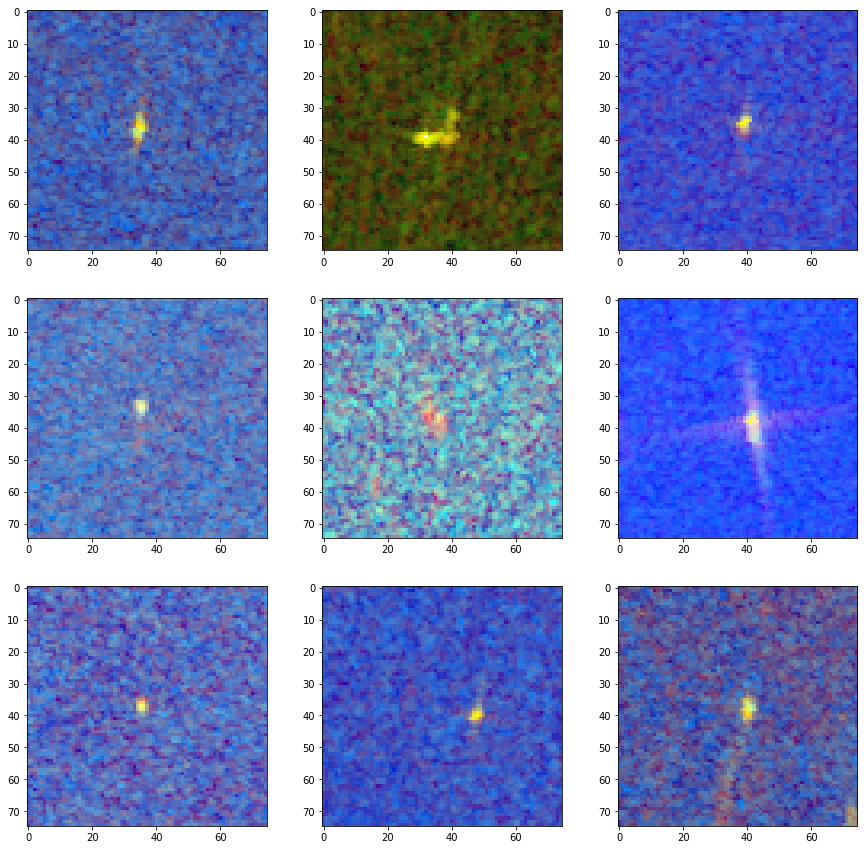

In [40]:
# look at random ships
print('Looking at random ships')
ships = np.where(train.is_iceberg ==0)[0]
ships_rand = np.random.choice(ships,9)
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = rgb_train[ships[i], :, :]
    ax.imshow(arr)   
plt.show()

Looking at random iceberg


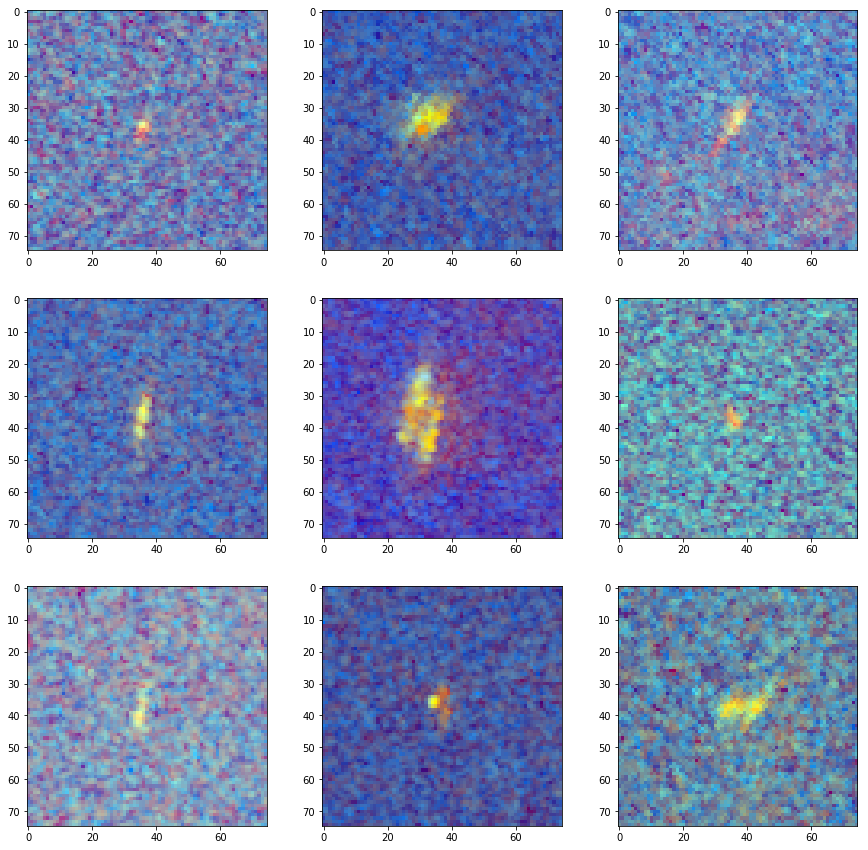

In [41]:
# look at random icebergs
print('Looking at random iceberg')
icebergs = np.where(train.is_iceberg ==1)[0]
icebergs_rand = np.random.choice(icebergs, 9)
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = rgb_train[icebergs[i], :, :]
    ax.imshow(arr)   
plt.show()

In [7]:
# another way to visualiza band_1
#plotmy3d(rgb_train[12,:,:,0], 'iceberg')

# From pseudo RGB to HSV

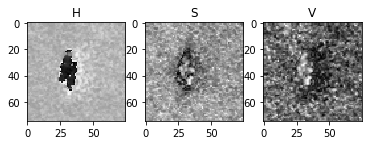

In [8]:
#HSV_train = RGB_to_HSV(rgb_train)
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
ax1.imshow(hsv_train[12,:,:,0],cmap = 'gray')
ax2.imshow(hsv_train[12,:,:,1],cmap = 'gray')
ax3.imshow(hsv_train[12,:,:,2],cmap = 'gray')
ax1.set_title('H')
ax2.set_title('S')
ax3.set_title('V')
plt.show()

In [9]:
import pywt
import math
wavelet = pywt.Wavelet('haar')
levels  = math.floor( np.log2(HSV_train[12,:,:,2].shape[0]) )
#coeffs = pywt.wavedec2(HSV_train[12,:,:,2], 'db1')
#np.size(coeffs[2])
WaveletCoeffs = pywt.wavedec2( HSV_train[12,:,:,2], wavelet, level=levels)

NameError: name 'HSV_train' is not defined

In [ ]:
noiseSigma = 10
threshold = noiseSigma*np.sqrt(2*np.log2(HSV_train[12,:,:,2].size))
NewWaveletCoeffs = map (lambda x: pywt.thresholding.soft(x,threshold),WaveletCoeffs)
NewWaveletCoeffs
#NewImage = pywt.waverec2( NewWaveletCoeffs, wavelet)

In [ ]:
plt.imshow(lee_filter(hsv_train[12,:,:,2], 5), cmap='gray')

## Filter images

In [11]:
HSV_train_filtered = np.zeros_like(hsv_train)

for i in range(np.shape(hsv_train)[0]):
    HSV_train_filtered[i,:,:,0] = hsv_train[i,:,:,0]
    HSV_train_filtered[i,:,:,1] = hsv_train[i,:,:,1]
    HSV_train_filtered[i,:,:,2] = lee_filter(hsv_train[i,:,:,2], 5)
    
RGB_train_filtered = HSV_to_RGB(HSV_train_filtered)

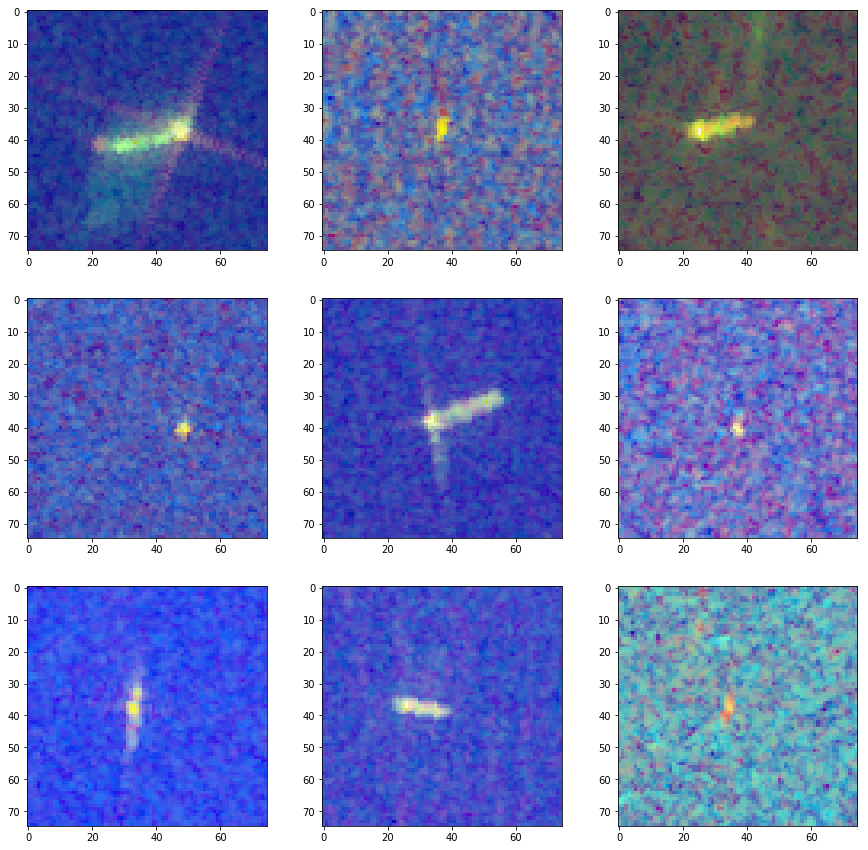

In [17]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = RGB_train_filtered[ships[i], :, :]
    ax.imshow(arr)   
plt.show()

In [42]:
import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 5),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),

                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                # Invert each image's chanell with 5% probability.
                # This sets each pixel value v to 255-v.
                iaa.Invert(0.05, per_channel=True), # invert color channels

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                iaa.Grayscale(alpha=(0.0, 1.0)),
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True)

ships_aug = seq.augment_images(RGB_train_filtered[ships,:,:,:])
icebergs_aug = seq.augment_images(RGB_train_filtered[icebergs,:,:,:])

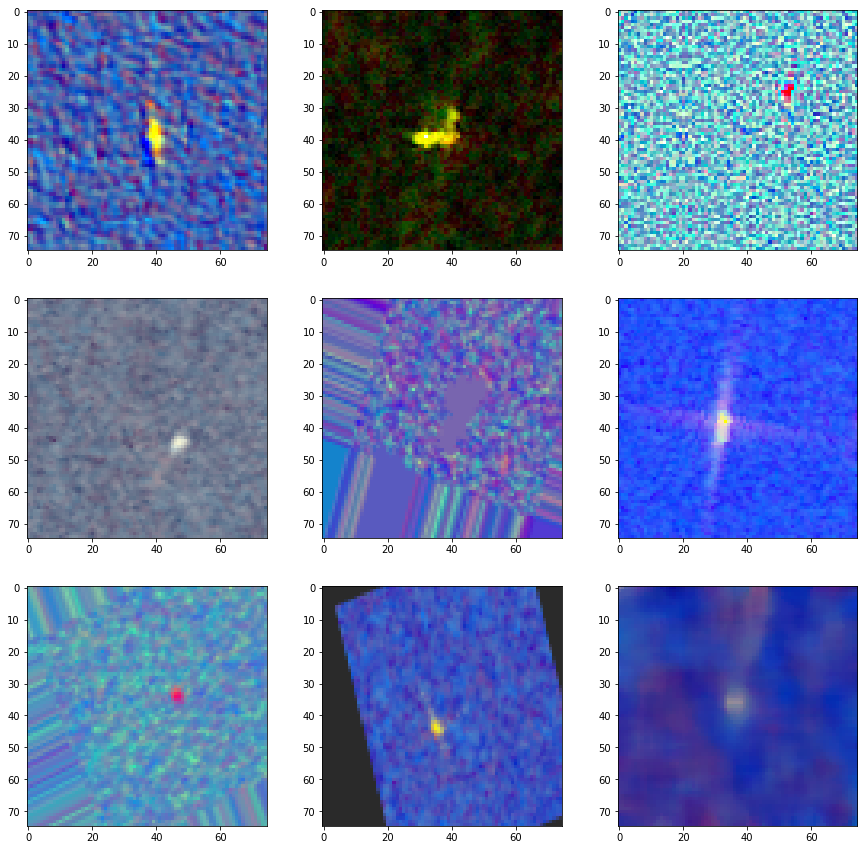

In [46]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = ships_aug[i, :, :]
    ax.imshow(arr)   
plt.show()

## Save the augmented data

In [52]:
ships_complete = np.concatenate((ships_aug,RGB_train_filtered[ships,:,:,:]))
icebergs_complete = np.concatenate((icebergs_aug,RGB_train_filtered[icebergs,:,:,:]))

ships_complete.dump('output/ships_complete.pickle')
icebergs_complete.dump('output/icebergs_complete.pickle')

df_ships = pd.DataFrame(data = flatten_img(ships_complete, np.zeros_like(ships_aug.shape[0]),\
                                           size = [75,75]), columns = ['H','S','V', 'is_iceberg'])


df_icebergs = pd.DataFrame(data = flatten_img(icebergs_complete, np.ones_like(iceberg_aug.shape[0]),\
                                           size = [75,75]), columns = ['H','S','V', 'is_iceberg'])


df_ = pd.concat([df_icebergs,df_ships])
df_.to_pickle('output/df_augmented_complete.pickle')
#df_.to_json('output/df_augmented_complete.json',orient='records')

TypeError: � (0d array) is not JSON serializable at the moment

In [ ]:
from cnn_build import *
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [ ]:
target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(HSV_train_filtered, target_train,\
                                                            random_state=1, train_size=0.75)
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

In [ ]:
train_p = pd.read_json('augmented.json', orient='records')

In [ ]:
#define our model
"""
def getModel(input_shape):
    if input_shape is None:
        input_shape = (75, 75, 3)
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))
    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=5):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=10)
"""